In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [2]:
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader, create_value_transform
from omegaconf import OmegaConf
value_transform = create_value_transform(OmegaConf.create({'mapping': 'arcsinh', 'bias': 'sample', 'scale': 'sample-range'}), None)

In [3]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
# from parsing import prods_to_prefix, logits_to_prefix, logits_to_prods, eval_from_logits
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader, create_value_transform
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from typing import Union, List, Dict
torch.manual_seed(42)
torch.set_grad_enabled(False)

# faithful-resonance-144: 24ryl3yz (0.7M params, 0.4M data)
# neat-leaf-286: zrfkvnvd (0.7M params, 1.2M data)
# decent-violet-288: gxdcuae8 (2.5M params, 1.2M data)
# flowing-sweep-41: 73qsce4t
# hpk9rdi1 <- next one , 367
# 6yxgapfx, D=32, 
# q8cgz70q, D=32, no contrastive loss

# Load model and dataset
model, cfg = load_wandb_model(run='n3gnm11h', name='last.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../model/config.yaml')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

# Quickfix (FIXME)
value_transform = create_value_transform({'mapping': 'arcsinh', 'bias': 'sample', 'scale': 'sample-range'}, None)

Imported model from run "n3gnm11h".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 8.9 M  | eval
1 | decoder       | Decoder      | 6.6 M  | eval
2 | value_decoder | ValueDecoder | 6.4 M  | eval
------------------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.677    Total estimated model params size (MB)
0         Modules in train mode
101       Modules in eval mode
Using dataset "dataset_241204_2" of size 1840811
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 1840811 | Batch: 512   | Batches: 3596 
  | valid        | Size: 204534  | Batch: 512   | Batches: 400  
---------------------------------------------------------------------


AttributeError: 'dict' object has no attribute 'mapping'

## Latent space distribution (+ samples for later use)

In [4]:
def encode_and_sample_dataset(model, data_loader, cfg, batch_size=2**15, max_data_len=None, calc_var_stats=False):
    if max_data_len is not None:
        assert batch_size <= max_data_len, 'Batch size must be less than max_data_len'
        num_samples = min(len(data_loader.dataset), max_data_len)
    else:
        num_samples = len(data_loader.dataset)

    print(f'Number of samples: {len(data_loader.dataset)} (dataloader), {num_samples} (encoded)')
    z_size = cfg.model.z_size
    
    mu = np.empty([num_samples, z_size])
    z = np.empty([num_samples, z_size])

    if calc_var_stats:
        mean_of_var = np.empty(num_samples)
        std_of_var = np.empty(num_samples)
    else:
        mean_of_var, std_of_var = None, None
    
    for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=batch_size, max_length=max_data_len)):
        mean, ln_var = model.encoder(x)
        
        start_idx, end_idx = i * batch_size, (i + 1) * batch_size

        mu[start_idx:end_idx, :] = mean.detach().numpy()
        z[start_idx:end_idx, :] = model.sample(mean, ln_var).detach().numpy()

        if calc_var_stats:
            var = ln_var.exp() * cfg.training.sampling.eps**2  # Effective var
            mean_of_var[start_idx:end_idx] = var.mean(dim=1).detach().numpy()
            std_of_var[start_idx:end_idx] = var.std(dim=1).detach().numpy()
    
    return mu, z, mean_of_var, std_of_var

mu_train, z_train, mean_of_var_train, std_of_var_train = encode_and_sample_dataset(model, train_loader, cfg, calc_var_stats=False, max_data_len=2**16)
mu_test, z_test, mean_of_var_test, std_of_var_test = encode_and_sample_dataset(model, test_loader, cfg, calc_var_stats=False, max_data_len=2**16)

Number of samples: 1840811 (dataloader), 65536 (encoded)
Number of samples: 204534 (dataloader), 65536 (encoded)


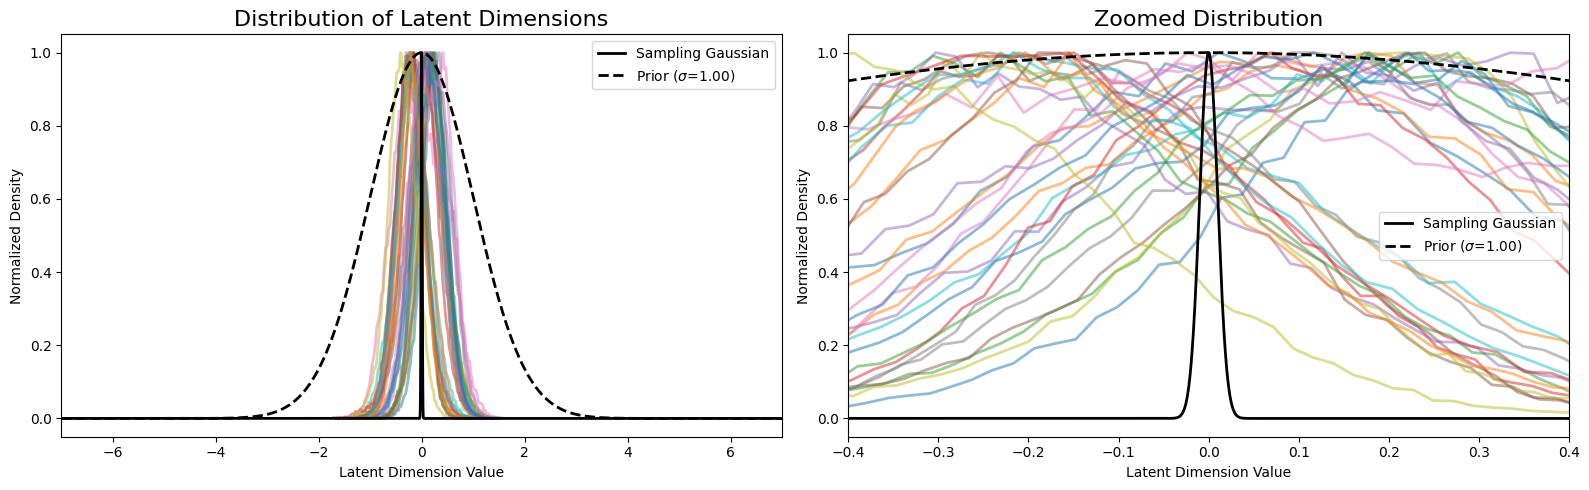

In [5]:
# plot_var_distributions(mean_of_var_train, mean_of_var_test, std_of_var_train, std_of_var_test)
plot_latent_distribution(mu_train, cfg)

## Examine neighbourhood in latent space of training samples 
Encode expression into latent space, sample from neighbourhood and then decode value. Done for 16 different expressions

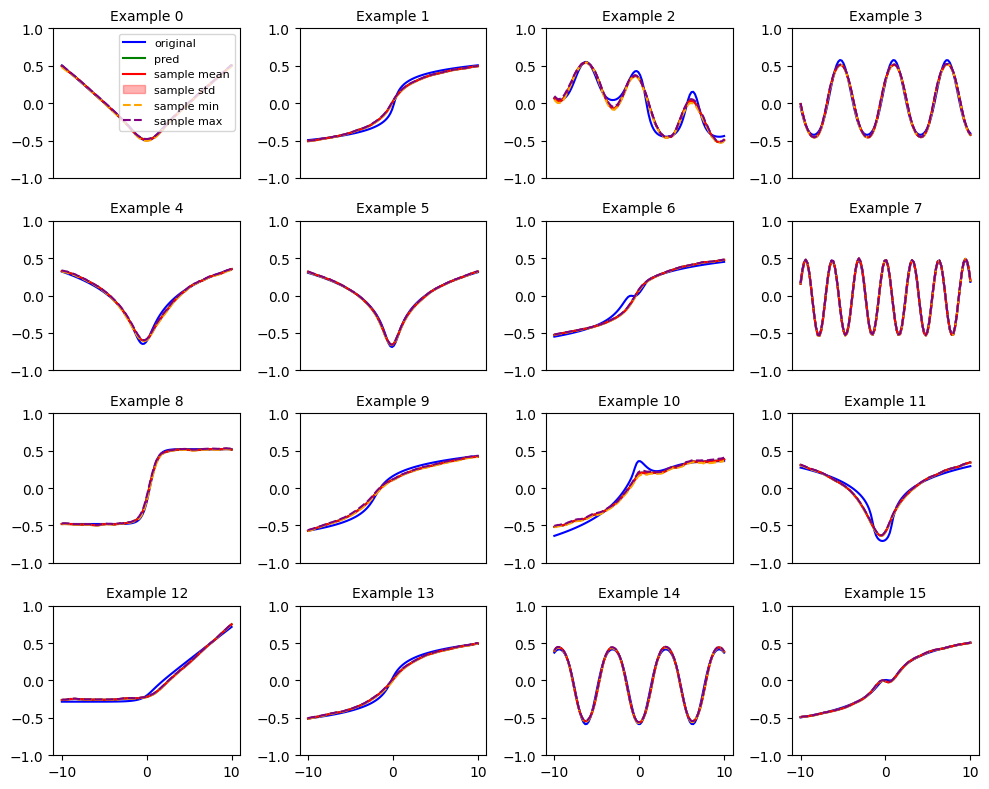

In [36]:
# Sampling with decoder -> eval
from debug_util import calc_and_plot_samples_grid

# model.sampling_eps = 1e-1

start_idx = 0
idx = range(start_idx, start_idx+16)
n_samples = 100

data_loader = train_loader
x = data_from_loader(data_loader, 'x', idx=idx)
values_true = data_from_loader(data_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='value', val_x=val_x, value_transform=value_transform, var_multiplier=1, use_const_var=False)

Encode into latent space, sample from neighbourhood, decode expression and evaluate it.

Evaluating neighbourhood, might take a while.:  38%|███▊      | 38/100 [00:00<00:00, 180.04it/s]/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/debug_util.py:421: RuntimeWarning: overflow encountered in cast
  res = res_raw.astype(np.float32)
Evaluating neighbourhood, might take a while.: 100%|██████████| 100/100 [00:00<00:00, 217.47it/s]


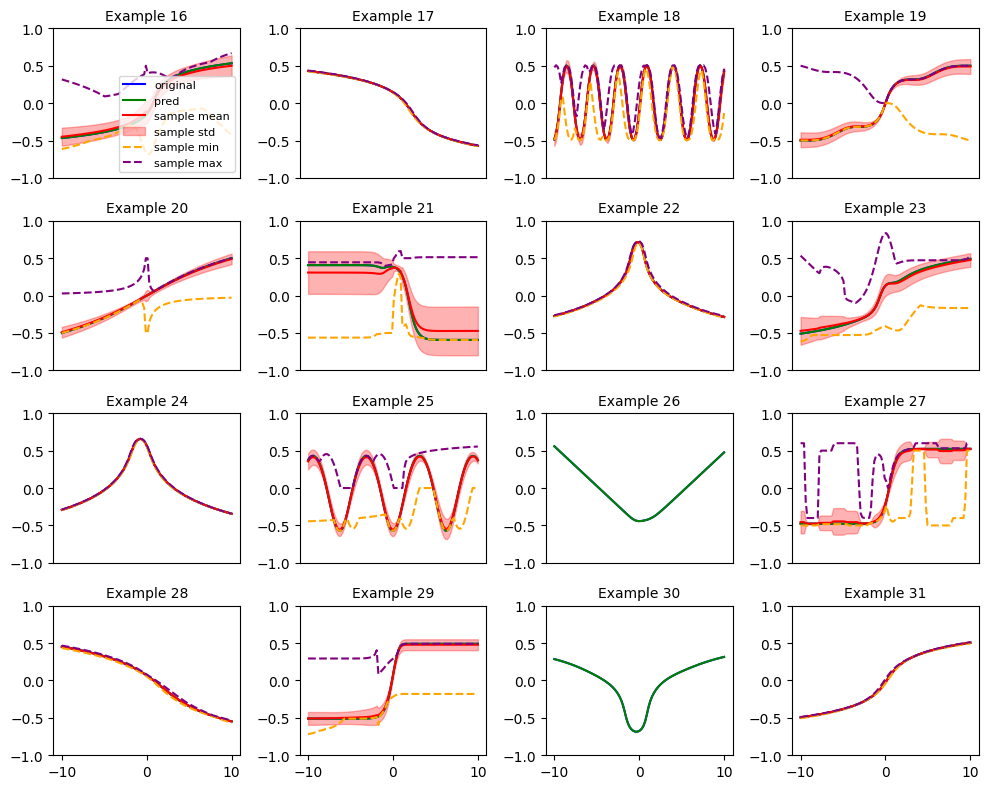

In [43]:
# Sampling with decoder -> eval
from debug_util import calc_and_plot_samples_grid

# model.sampling_eps = 1e-1

start_idx = 16
idx = range(start_idx, start_idx+16)
n_samples = 100

data_loader = train_loader
x = data_from_loader(data_loader, 'x', idx=idx)
values_true = data_from_loader(data_loader, 'values', idx=idx)

calc_and_plot_samples_grid(model, x, values_true, n_samples, idx, mode='syntax', val_x=val_x, value_transform=value_transform, var_multiplier=10, use_const_var=False)

## Closer analysis of neighbourhood expression decoding

In [25]:
from parsing import logits_to_infix, eval_from_logits

In [81]:
i = 4
val_orig = data_from_loader(train_loader, 'values', idx=i)
x = data_from_loader(train_loader, 'x', idx=i)
n_samples = 100
var_multiplier = 16
mean, ln_var = model.encoder(x)
ln_var = ln_var + torch.log(torch.ones_like(ln_var) * var_multiplier)
z = model.sample(mean.repeat(n_samples, 1), ln_var.repeat(n_samples, 1))
logits_neigh = model.decoder(z)

In [82]:
sp.sympify(logits_to_infix(x.squeeze(), sample=False, replace_const='numerical_rounded').lower())


1.05263157894737*x1

Plot all evaluated samples (maybe with filters)

In [83]:
exprs = []
vals = []
for logits in logits_neigh:
    infix_str = logits_to_infix(logits, sample=True, replace_const='numerical_rounded', round_const_decimals=2)
    infix_str_simpyfied = sp.sympify(infix_str.lower())
    res_raw = eval_from_logits(logits, val_x.squeeze())
    try:
        res = res_raw.astype(np.float32)
    except TypeError:
        pass
    exprs.append([infix_str, infix_str_simpyfied])
    vals.append(res)

# plt.plot(val_x.squeeze(), np.array([out[j][2] for j in range(len(out))]).T)

In [84]:
values_pred = value_transform(torch.tensor(vals)).detach().numpy()
first_derivative = np.diff(values_pred, axis=1) / np.diff(val_x, axis=0).T
second_derivative = np.diff(first_derivative, axis=1) / np.diff(val_x[:-1], axis=0).T
third_derivative = np.diff(second_derivative, axis=1) / np.diff(val_x[:-2], axis=0).T
fourth_derivative = np.diff(third_derivative, axis=1) / np.diff(val_x[:-3], axis=0).T
is_valid = (np.all(np.abs(first_derivative) < 100, axis=1) & \
            np.all(np.abs(second_derivative) < 100, axis=1) & \
            np.all(np.abs(third_derivative) < 100, axis=1) & \
            np.all(np.abs(fourth_derivative) < 100, axis=1) & \
            np.all(np.abs(values_pred) < 10, axis=1))

In [85]:
is_valid

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

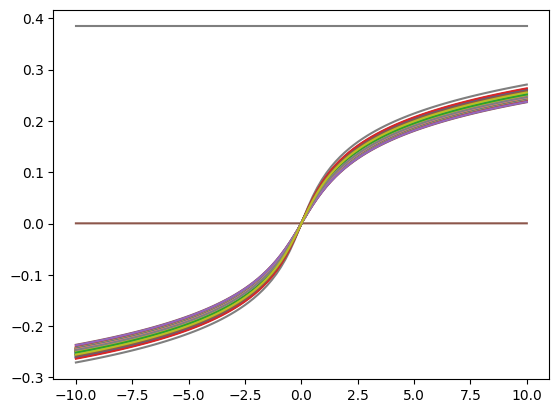

In [86]:
plt.plot(val_x.squeeze(), values_pred[is_valid, :].T)

Compare simplified samples expressions (might want the non-simplified ones, too)

In [36]:
const_idx = np.where(np.array(syntax_cats) == 'CON')[0]

prod_idx = torch.argmax(logits_neigh[:, :, :-1], dim=-1)
prod_idx_unique = torch.unique(prod_idx, dim=0)

invalid = 0
out = []
for prod_idx_here in prod_idx_unique:
    mask = torch.all(prod_idx == prod_idx_here, dim=1)  # Mask for all samples with same production rule
    logits = logits_neigh[np.where(mask)[0][0], ...].squeeze()
    
    infix_str = logits_to_infix(logits, sample=True, replace_const='numerical_rounded', round_const_decimals=2)
    infix_str_simpyfied = sp.sympify(infix_str.lower())

    res_raw = eval_from_logits(logits, val_x.squeeze())
    try:
        res = res_raw.astype(np.float32)
    except TypeError:
        invalid += 1
        res = np.zeros_like(res_raw, dtype=np.float32)
    values_pred = value_transform(torch.tensor(res))

    out.append([infix_str, infix_str_simpyfied, values_pred])
    
print(f'Unique expressions: {len(out)} out of {n_samples}; Invalid: {invalid}')

Unique expressions: 9 out of 100; Invalid: 0


In [60]:
j = 9
out[j][1]

IndexError: list index out of range

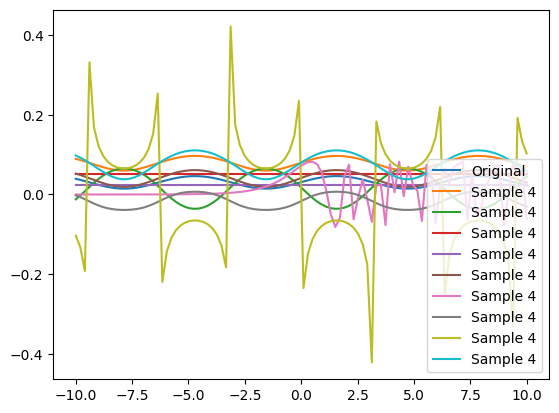

In [49]:
val_orig = data_from_loader(train_loader, 'values', idx=i)
plt.plot(val_x.squeeze(), val_orig.squeeze().detach().numpy(), label='Original')
plt.plot(val_x.squeeze(), np.array([out[j][2] for j in range(len(out))]).T, label=f'Sample {j}')
plt.legend()
plt.show()

In [58]:
for a, b in res:
    print(b)


x1*exp(0.16*x1)/(2*x1 - 0.24)
0.46*x1**3
0.26*x1**2/(x1 - 0.32)
x1**2
(-0.11 + exp(x1)/(x1 - 0.41))/x1
2.85714285714286*(0.31*x1*(x1 - 0.45) - x1)/x1
zoo*x1**2*(x1 - 0.52)
3.03030303030303*x1*(0.07*x1 - 0.0063)
0
0.0735151673021299*exp(x1)
1.32312981233744*x1 - 0.63510230992197
3.2258064516129*(0.08*x1 - 0.0424)/x1
0.166666666666667*x1/(x1 - 0.37)
4.76190476190476*(x1 - 0.15)/x1
3.33333333333333*(2*x1 - 0.25)/x1
5.55555555555556*x1*(2*x1 - 0.39)
3.84615384615385*x1**2*(x1 - 0.23)
0.878095430920561*x1 - 0.254647674966963
2.38095238095238*x1 - 0.69047619047619
x1*(x1 - 0.41)*exp(-x1)
-11.1111111111111*x1*(x1 - 0.26)
-100.0*x1*(x1 - 0.31)
x1 - 0.39
6.45161290322581*x1
-4.34782608695652*x1 - 1.08695652173913
78.6627861066553*x1/(x1 - 0.37)
1/(x1 - 0.44)
exp(x1)/(x1 - 0.54)
exp(x1)/(x1 - 0.39)
0
3.7037037037037*x1/(2*x1 - 0.3)
6.25*x1**2/(2*x1 - 0.45)
x1/(x1 - 0.44)
x1/(x1 - 0.23)
x1/(x1 - 0.41)
1
0
0.0100000000000000
0.670320046035639/(x1 - 0.39)
4.34782608695652/(x1 - 0.47)


In [25]:
const_idx = np.where(np.array(syntax_cats) == 'CON')[0]

prod_idx = torch.argmax(logits_neigh[:, :, :-1], dim=-1)
prod_idx_unique = torch.unique(prod_idx, dim=0)
for prod_idx_here in prod_idx_unique:
    mask = torch.all(prod_idx == prod_idx_here, dim=1)
    if (cnt := sum(mask)) > 0:

        infix_str = logits_to_infix(logits_neigh[np.where(mask)[0][0], ...].squeeze(), sample=False, replace_const='placeholder')
        print(f'-- Expression: {infix_str}; Simplified: {sp.sympify(infix_str.lower())}')
        print(f'Number of samples: {cnt}')

        tmp = np.where(prod_idx_here == const_idx)[0]
        for j, const_pos in enumerate(tmp):

            consts = logits_neigh[mask, const_pos, -1]
            consts_mean = consts.mean(dim=0).item()
            consts_std = consts.std(dim=0).item()
            const_min = consts.min(dim=0).values.item()    
            const_max = consts.max(dim=0).values.item()

            print(f'CON_{j}: Mean: {consts_mean:.2f}; Std: {consts_std:.2f}; Min: {const_min:.2f}; Max: {const_max:.2f}; Unique: {len(consts.unique())}')

-- Expression: (x1*((x1*(CON_0+x1))/x1))*(EXP(CON_1)*CON_2); Simplified: con_2*x1*(con_0 + x1)*exp(con_1)
Number of samples: 1
CON_0: Mean: -0.45; Std: nan; Min: -0.45; Max: -0.45; Unique: 1
CON_1: Mean: 0.31; Std: nan; Min: 0.31; Max: 0.31; Unique: 1
-- Expression: (x1+((x1*(CON_0+x1))*x1))/(x1*CON_1); Simplified: (x1**2*(con_0 + x1) + x1)/(con_1*x1)
Number of samples: 1
CON_0: Mean: -0.25; Std: nan; Min: -0.25; Max: -0.25; Unique: 1
CON_1: Mean: 0.11; Std: nan; Min: 0.11; Max: 0.11; Unique: 1
-- Expression: (x1+((((CON_0+x1)+x1)*(x1*CON_1))/x1))/(S+S); Simplified: (con_1*(con_0 + 2*x1) + x1)/(2*s)
Number of samples: 1
CON_0: Mean: -0.31; Std: nan; Min: -0.31; Max: -0.31; Unique: 1
CON_1: Mean: 0.40; Std: nan; Min: 0.40; Max: 0.40; Unique: 1
-- Expression: (x1+((x1*(CON_0+x1))/x1))/(x1*CON_1); Simplified: (con_0 + 2*x1)/(con_1*x1)
Number of samples: 1
CON_0: Mean: -0.38; Std: nan; Min: -0.38; Max: -0.38; Unique: 1
CON_1: Mean: 0.12; Std: nan; Min: 0.12; Max: 0.12; Unique: 1
-- Express

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_8425/2129392659.py:32: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  consts_std = consts.std(dim=0).item()


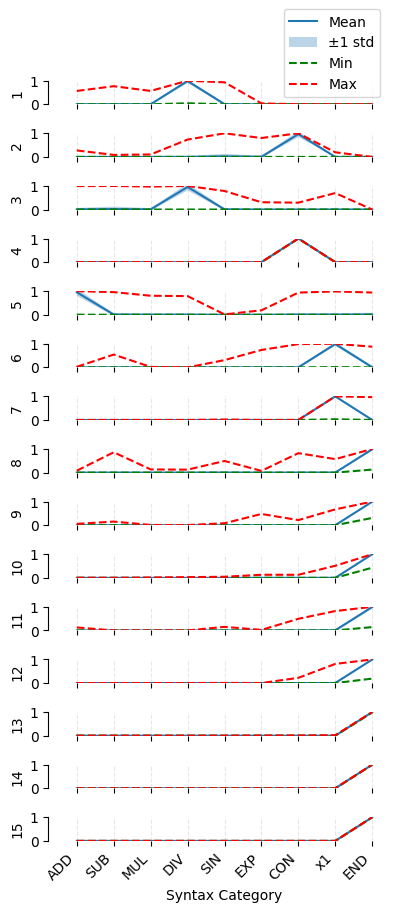

In [130]:
import torch.nn.functional as F

n = 0
i = 0
N = 16
x = data_from_loader(train_loader, 'x', idx=range(i, i+N))

# Encode into latent space
mean, ln_var = model.encoder(x)
logits = model.decoder(mean, max_length=15)
values = model.value_decoder(mean)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = model.sample(mean, ln_var)  # Sample from neighbourhood in latent space
    logits = model.decoder(z, max_length=15)
    samples.append(logits.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2, 3)
syntax_samples = samples[:, :, :, :-1]
syntax_samples = F.softmax(torch.tensor(syntax_samples), dim=-1).numpy()
consts_samples = samples[:, :, :, -1]

mean_samples = np.mean(syntax_samples, axis=1)
std_samples = np.std(syntax_samples, axis=1)
min_samples = np.min(syntax_samples, axis=1)
max_samples = np.max(syntax_samples, axis=1)

fig, axes = plt.subplots(mean_samples.shape[1], 1, figsize=(4, 0.6*mean_samples.shape[1]), sharex=True)
plt.subplots_adjust(hspace=0)  # Remove vertical space between subplots
for i in range(mean_samples.shape[1]):
    axes[i].plot(mean_samples[n, i, :], label='Mean')
    axes[i].fill_between(range(mean_samples.shape[2]),
                         mean_samples[n, i, :] - std_samples[n, i, :],
                         mean_samples[n, i, :] + std_samples[n, i, :],
                         alpha=0.3, label='±1 std')
    axes[i].plot(min_samples[n, i, :], label='Min', linestyle='--', color='green')
    axes[i].plot(max_samples[n, i, :], label='Max', linestyle='--', color='red')
    axes[i].set_xticks(range(len(syntax_cats)))
    axes[i].set_xticklabels(syntax_cats, rotation=45, ha='right')
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.3)
    axes[i].set_ylim(0, 1)  # Set y-limit between 0 and 1
    axes[i].set_ylabel(f'{i+1}')  # Add y-label showing timestep
    if i == mean_samples.shape[1] - 1:
        axes[i].set_xlabel('Syntax Category')
    if i == 0:
        axes[i].legend()
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['bottom'].set_visible(False)  # Remove bottom border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].spines['left'].set_position(('outward', 10))  # Move left spine outward

plt.tight_layout()
plt.subplots_adjust(right=0.98)  # Reduce right margin
plt.show()

## Mean distance

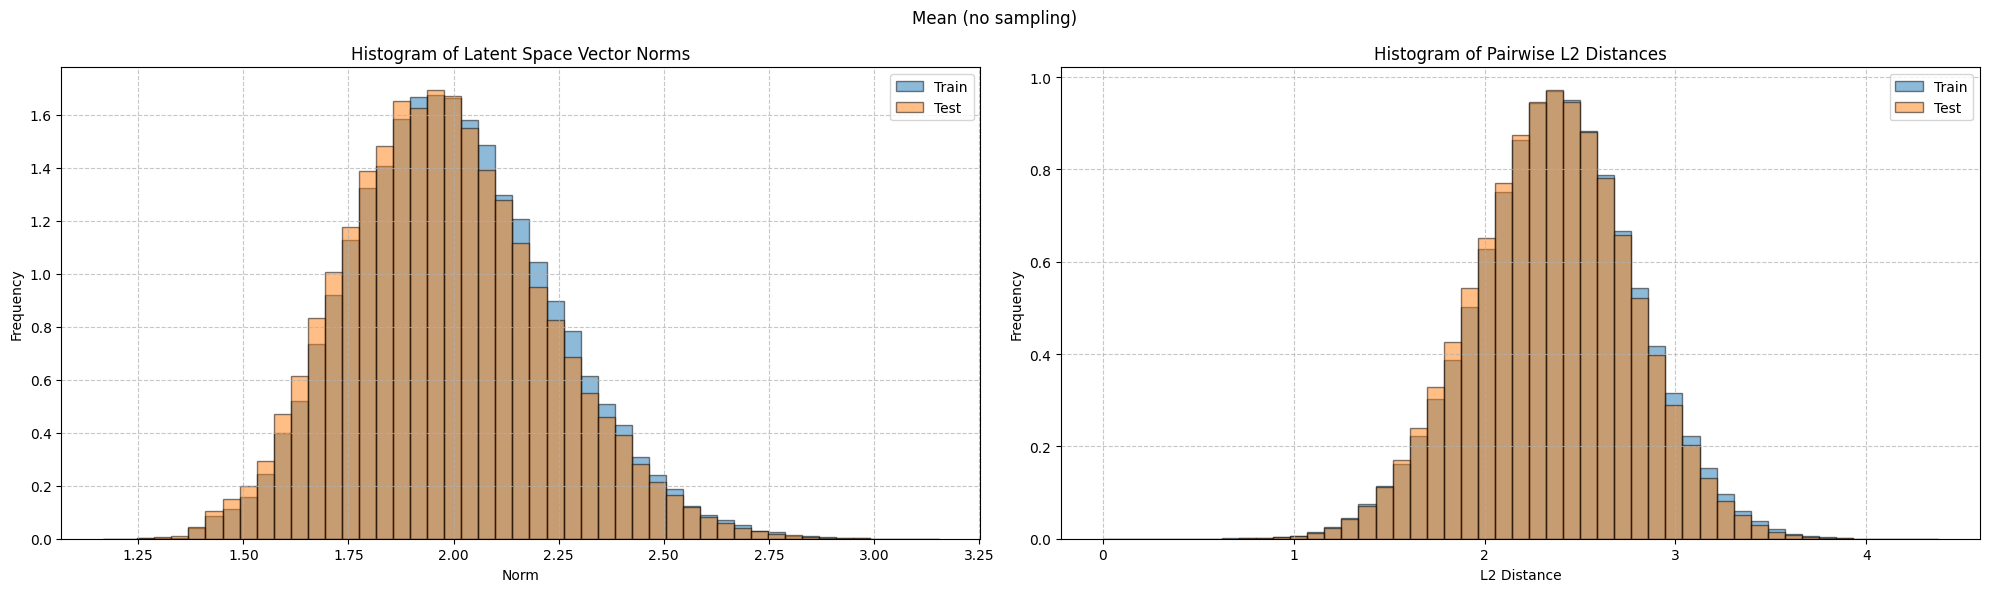

In [8]:
from debug_util import plot_latent_distances

plot_latent_distances(mu_train, mu_test, 'Mean (no sampling)')

In [57]:
a = mu_train

sample_size = 10000
sampled_train = a[np.random.choice(a.shape[0], sample_size, replace=False)]
pairwise_distances_train = np.sum(sampled_train[:, np.newaxis] * sampled_train, axis=2)
l2_distances_train = pairwise_distances_train[np.triu_indices(sample_size, k=1)]

plt.hist(l2_distances_train, bins=50)

## Interpolation study

Distance: 2.1248750466638655


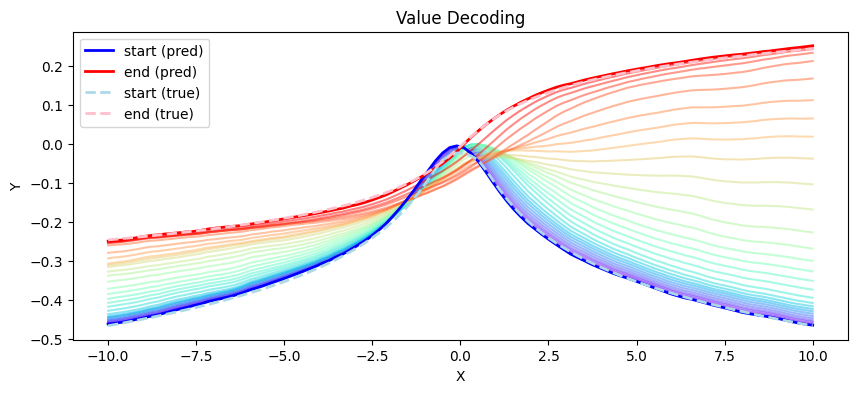

In [77]:
## Value decoding only (for models with no expression decoder)
import debug_util
reload(debug_util)
from debug_util import plot_value_interpolation, slerp

# Parameters
i, j = 1, 5
num_steps = 30
interp_mode = 'slerp'

# Get data
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()


print(f'Distance: {np.linalg.norm(z_end - z_start)}')

# Interpolate in latent space
alpha = np.linspace(0, 1, num_steps)
if interp_mode == 'slerp':
    z_interp = slerp(z_start, z_end, alpha)
elif interp_mode == 'linear':
    z_interp = z_start[np.newaxis, ...] * (1 - alpha[:, np.newaxis]) + z_end[np.newaxis, ...] * alpha[:, np.newaxis]
else:
    raise ValueError(f'Interpolation mode {interp_mode} not supported')

# Decode into values and logits
values_interp = model.value_decoder(torch.tensor(z_interp.astype(np.float32)))


fig, ax1 = plt.subplots(figsize=(10, 4))
plot_value_interpolation(ax1, val_x, values_interp, start_true, end_true, 'Value Decoding')

In [31]:
reload(debug_util)
import grammar
reload(grammar)
import parsing
reload(parsing)
from debug_util import plot_interpolation

In [32]:
grammar.GCFG.productions()

[S -> 'ADD' S S,
 S -> 'SUB' S S,
 S -> 'MUL' S S,
 S -> 'DIV' S S,
 S -> 'SIN' S,
 S -> 'COS' S,
 S -> 'EXP' S,
 S -> 'TANH' S,
 S -> 'COSH' S,
 S -> 'SINH' S,
 S -> 'CON',
 S -> 'x1',
 END -> 'END']

In [11]:
value_transform

<function data_util.create_value_transform.<locals>.combined_transform(x)>

Distance: 2.7642788130242777


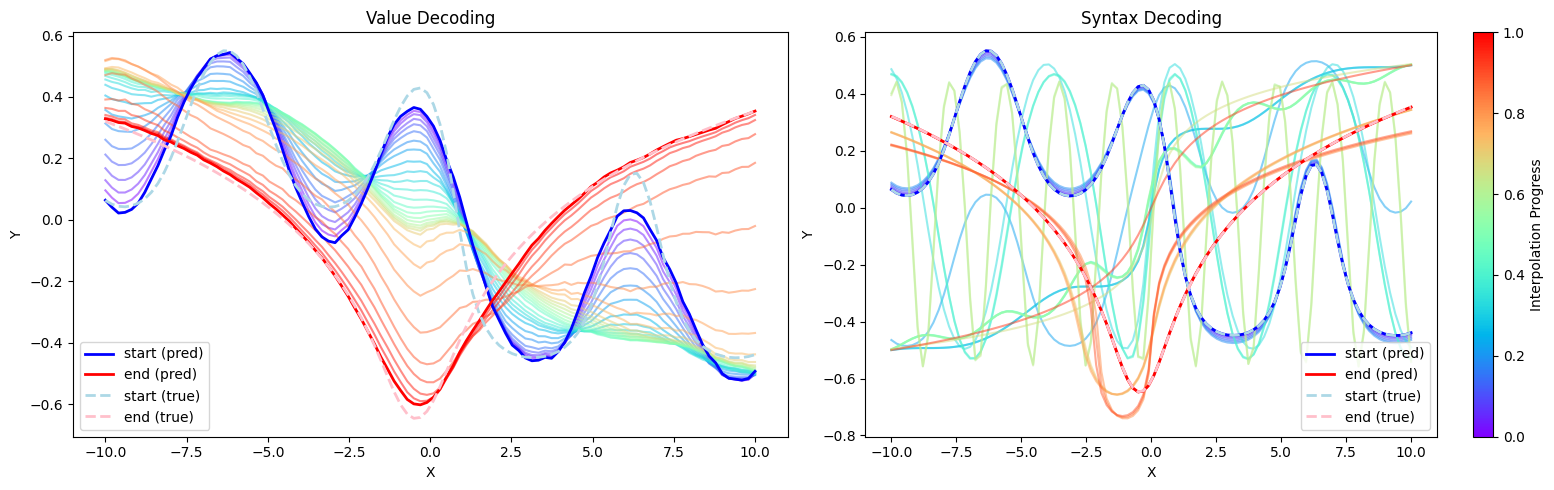

In [24]:
import debug_util
reload(debug_util)
from debug_util import plot_interpolation

i, j = 2, 4
z_start, z_end = mu_train[i], mu_train[j]
start_true = data_from_loader(train_loader, 'values', idx=i).squeeze().detach().numpy()
end_true = data_from_loader(train_loader, 'values', idx=j).squeeze().detach().numpy()

plot_interpolation(model, val_x, z_start, z_end, start_true, end_true, value_transform, num_steps=30, interp_mode='slerp')

In [ ]:
## Check orthogonality of z_train
target_idx = 0
z_target = 

In [46]:
z_train.shape

(65536, 32)

## Local vs global structuring

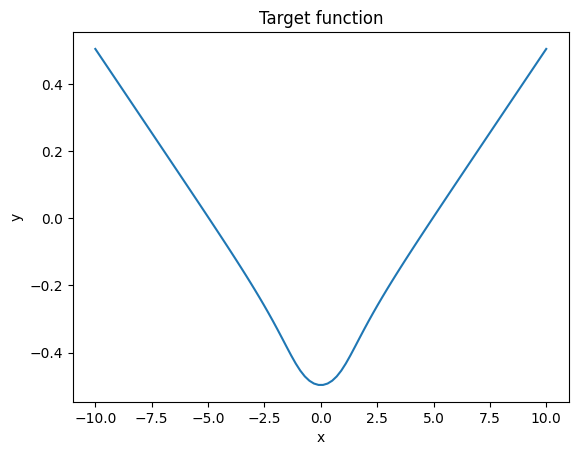

In [25]:
target_idx = 0
data_loader = train_loader  # FIXME: Only works with train_loader currently...
values = data_from_loader(data_loader, 'values', idx=target_idx)  

plt.plot(val_x.squeeze(), values.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [26]:
import seaborn as sns

N = 2**17
BATCH_SIZE = 2**15
use_u_only = True

z_slice = model.value_decoder.z_slice

values = data_from_loader(data_loader, 'values', max_length=N)
x = data_from_loader(data_loader, 'x', max_length=N)
z = torch.empty(N, model.cfg.model.z_size)
for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=BATCH_SIZE, max_length=N)):
    mean, ln_var = model.encoder(x)
    z[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = mean

target_values = values[target_idx, :]
target_z = z[target_idx, :]

dist_y = torch.mean((values - target_values)**2, dim=1)  # MSE

if not use_u_only:
    dist_z = torch.norm(z - target_z, dim=1)
else:
    dist_z = torch.norm(z[:, z_slice[0]:z_slice[1]] - target_z[z_slice[0]:z_slice[1]], dim=1)

mse_sorted = pd.Series(dist_y).sort_values()

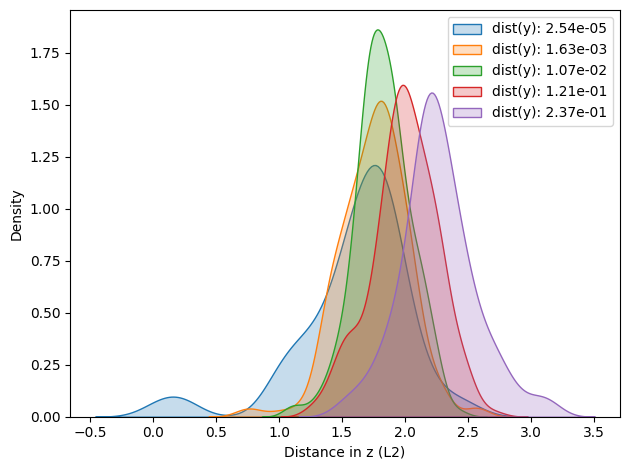

In [27]:
for i in [0, 3000, 10000, 20000, 80000]:
    idx = mse_sorted.index[i:i+200]
    sns.kdeplot(dist_z[idx], label=f'dist(y): {dist_y[idx].mean():.2e}', fill=True)
# plt.xlim(0, 2)
plt.legend()
plt.xlabel('Distance in z (L2)')
plt.tight_layout()
plt.show()


# # Create histogram version
# for i in [0, 3000, 10000, 20000, 80000]:
#     idx = mse_sorted.index[i:i+200]
#     plt.hist(dist_z[idx], bins=50, range=(0, dist_z.max().item()), alpha=0.5, label=f'dist(y): {dist_y[idx].mean():.2e}')
# plt.xlabel('Distance in z (L2)')
# plt.legend()
# plt.tight_layout()
# plt.show()


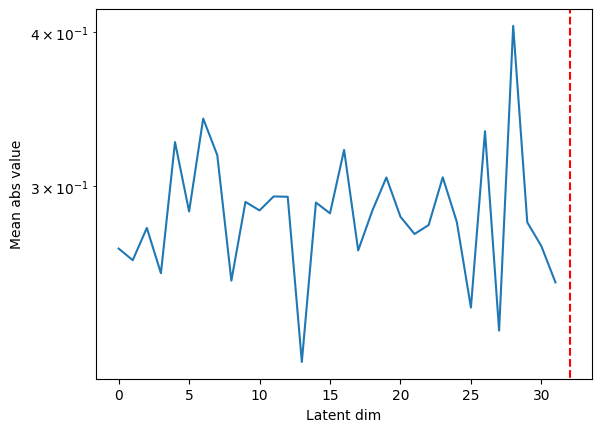

In [28]:
plt.plot(torch.mean(torch.abs(z), dim=0))
plt.yscale('log')
plt.xlabel('Latent dim')
plt.ylabel('Mean abs value')
plt.vlines(z_slice[1], 0, 1, color='r', linestyle='--') 
plt.show()

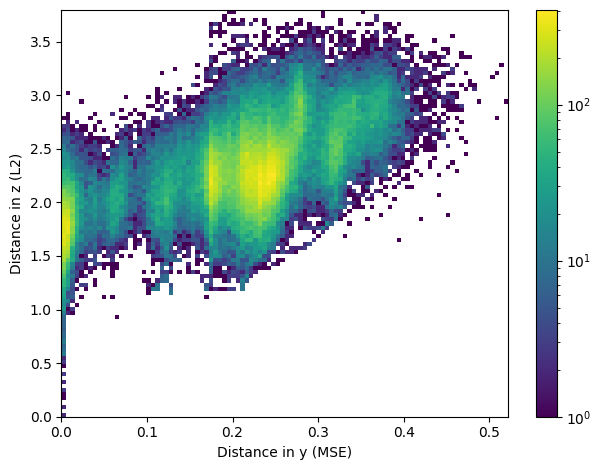

In [29]:
from matplotlib.colors import LogNorm

plt.hist2d(dist_y, dist_z, bins=[100, 100], norm=LogNorm())  # range=[(0, 1e-4), (0, 2)]
plt.colorbar()
plt.ylabel('Distance in z (L2)')
plt.xlabel('Distance in y (MSE)')
plt.tight_layout()
plt.show()

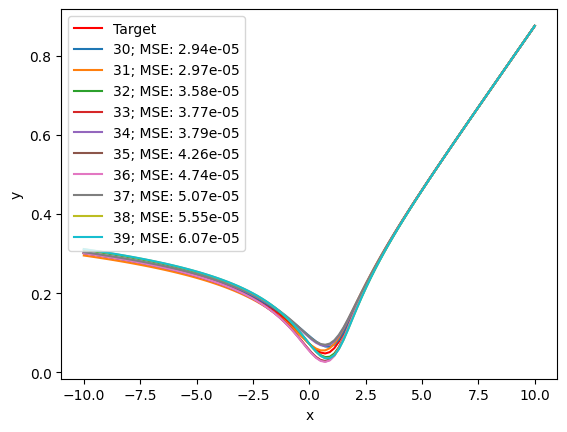

In [82]:
# Plot examples
i, n = int(3e1), 10
assert i < len(values), 'Index out of bounds'

plt.plot(val_x.squeeze(), target_values.squeeze().detach().numpy(), label='Target', color='r')
plt.plot(val_x.squeeze(), values[mse_sorted.index[i:i+n], :].detach().numpy().T, label=[f'{idx}; MSE: {mse_sorted.to_numpy()[idx]:.2e}' for idx in range(i, i+n)])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

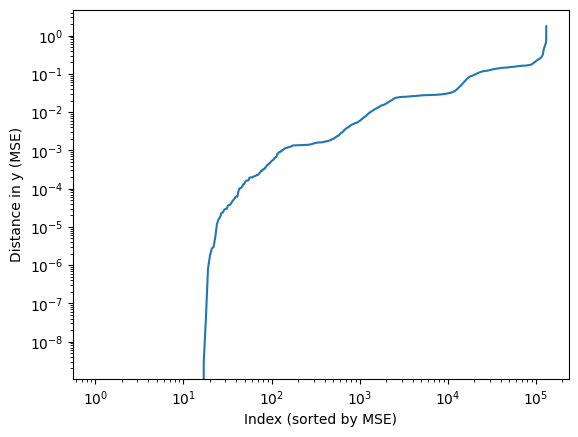

In [83]:
mse_sorted.reset_index(drop=True).plot(ylabel='MSE')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Distance in y (MSE)')
plt.xlabel('Index (sorted by MSE)')
plt.show()

In [84]:
# Syntax
i = 0
for x_here in x[mse_sorted.index[i:i+300], :]:
    res = logits_to_infix(x_here.squeeze(), sample=False, replace_const='numerical')
    sympy_expr = sp.sympify(res.lower())
    print(sympy_expr, res)


IndexError: index 109940 is out of bounds for dimension 0 with size 32768

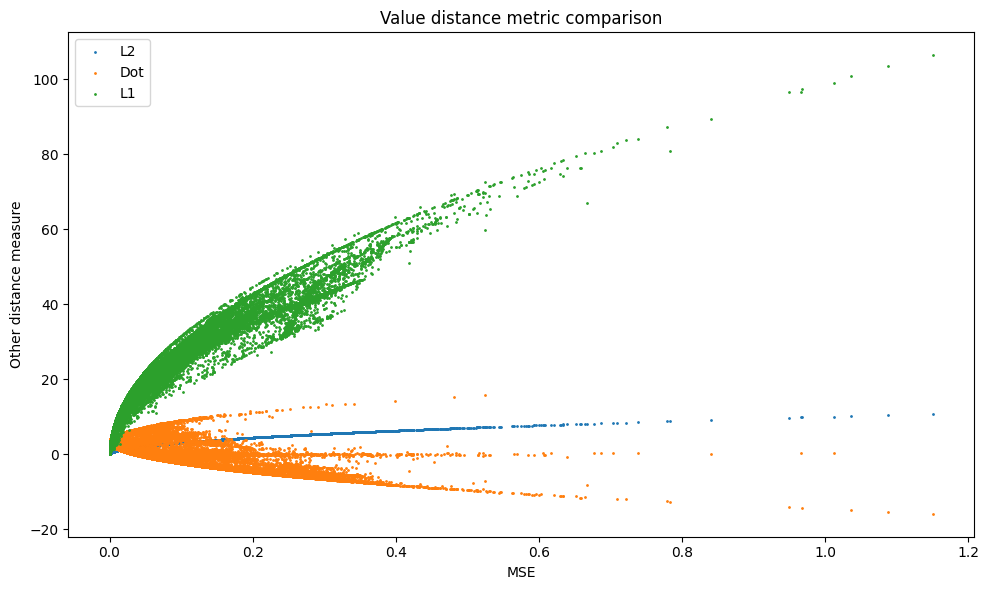

In [340]:
dist_y_L2 = torch.norm(values - target_values, dim=1)
dist_y_dot = torch.sum(values * target_values.unsqueeze(0), dim=1)
dist_y_L1 = torch.sum(torch.abs(values - target_values), dim=1)

plt.figure(figsize=(10, 6))
plt.scatter(dist_y, dist_y_L2, label='L2', s=1)
plt.scatter(dist_y, dist_y_dot, label='Dot', s=1)
plt.scatter(dist_y, dist_y_L1, label='L1', s=1)

plt.title('Value distance metric comparison')
plt.xlabel('MSE')
plt.ylabel('Other distance measure')
plt.legend()
plt.tight_layout()
plt.show()

## Property prediction (SNIP-inspired)

In [30]:
from debug_util import calc_properties, plot_tsne_properties, plot_property_distributions, plot_original_vs_predicted_properties, plot_values_with_property
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt     

BATCH_SIZE = 2**15

properties = np.empty((len(train_loader.dataset), 4))
for i, x in enumerate(data_from_loader(train_loader, 'values', batch_size=BATCH_SIZE)):
    mean, upwardness, oscillations, non_convexity_ratio = calc_properties(x)
    oscillations = np.log(oscillations + 1)
    properties[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = np.array([mean, upwardness, oscillations, non_convexity_ratio]).T

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_19493/2422307526.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  oscillations = np.log(oscillations + 1)


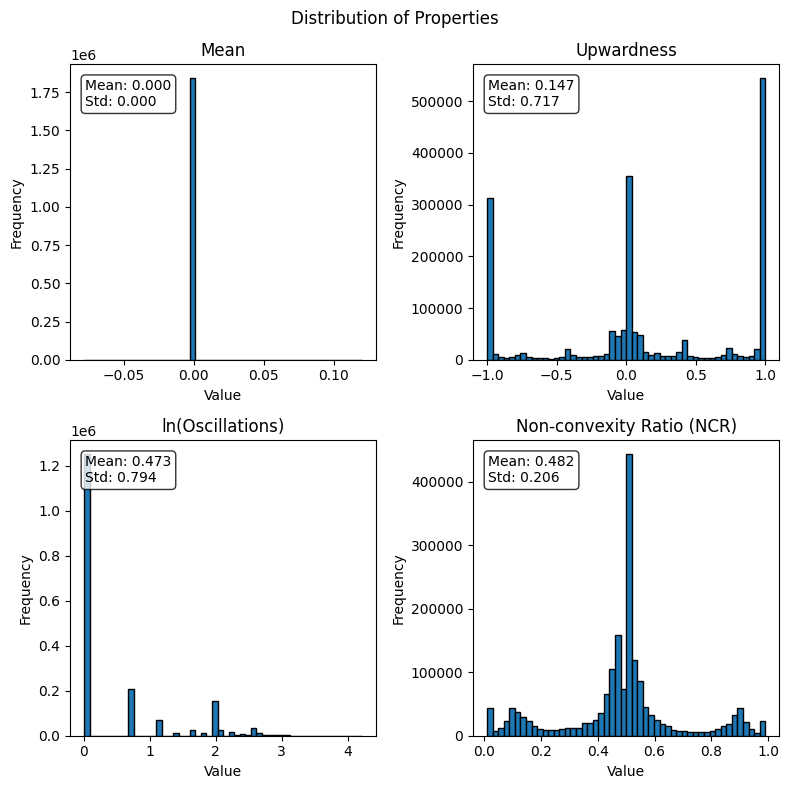

In [31]:
plot_property_distributions(properties)

In [32]:
n = 10000  # Number of samples to plot (tsne is slow!)
pca = PCA(n_components=6)
mu_train_pca = pca.fit_transform(mu_train[:n])
mu_train_2d = TSNE(n_components=2, random_state=42).fit_transform(mu_train_pca)

print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

Cumulative explained variance ratio: 0.4664


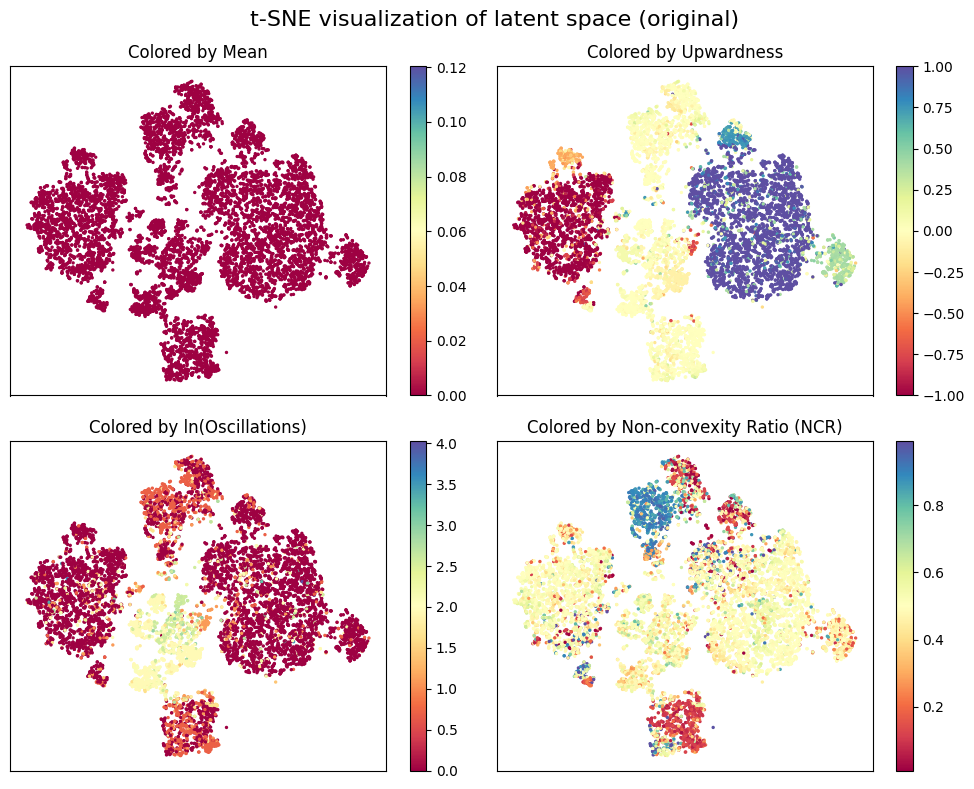

In [33]:
plot_tsne_properties(mu_train_2d, properties[:n], title='t-SNE visualization of latent space (original)')

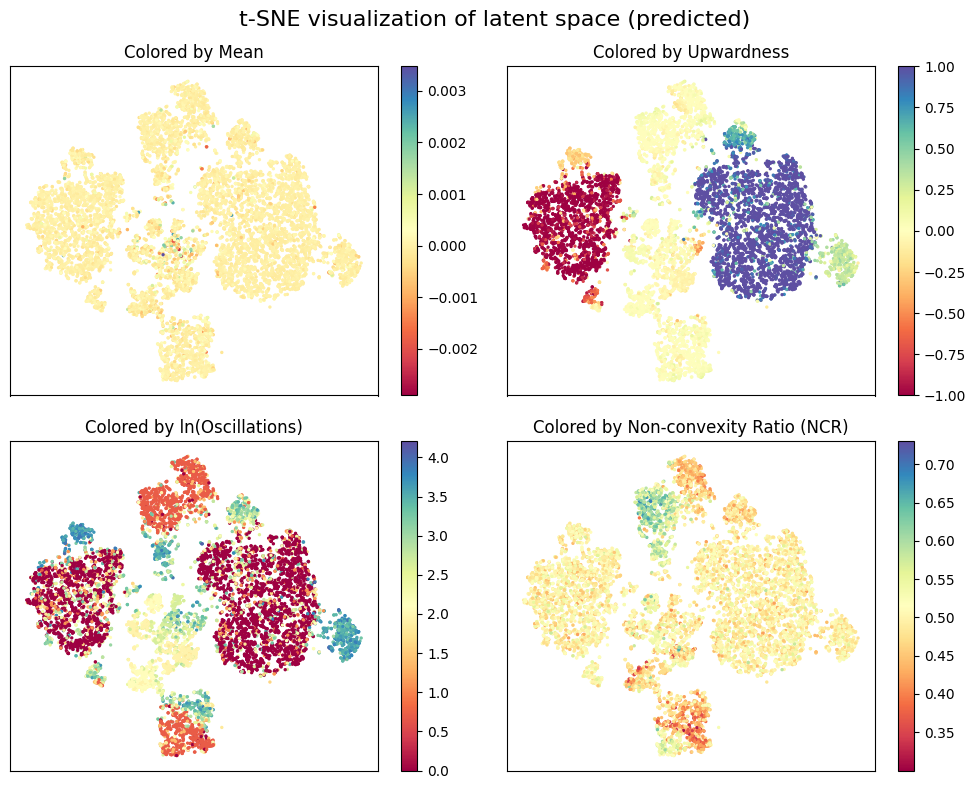

In [34]:
values_pred = model.value_decoder(torch.tensor(mu_train[:n]).float())
mean, upwardness, oscillations, non_convexity_ratio = calc_properties(values_pred)
properties_pred = np.array([mean, upwardness, torch.log(1+oscillations), non_convexity_ratio]).T

plot_tsne_properties(mu_train_2d, properties_pred[:n], title='t-SNE visualization of latent space (predicted)')

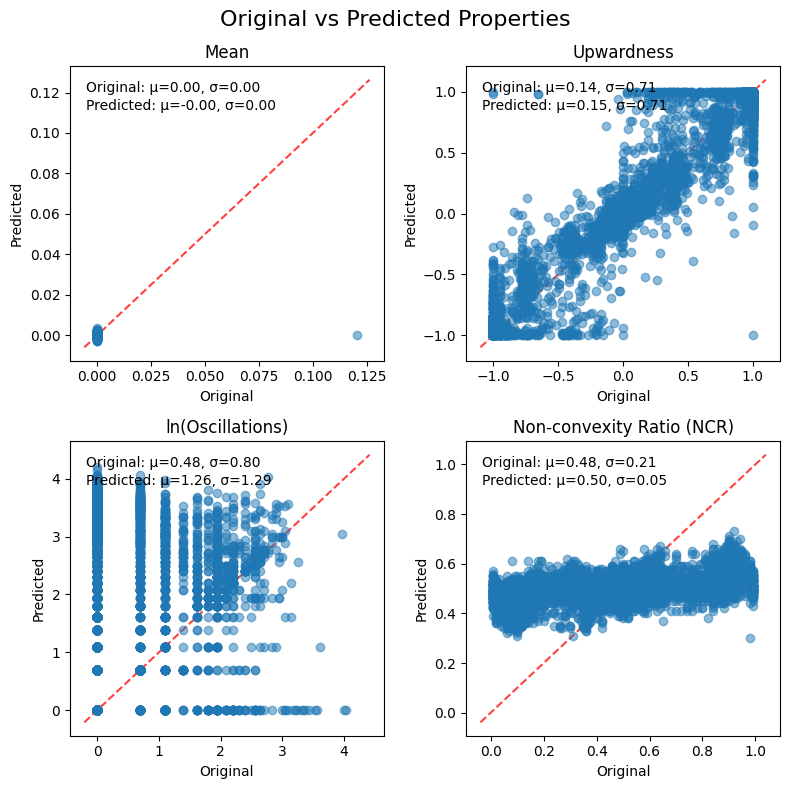

In [35]:
plot_original_vs_predicted_properties(properties[:n], properties_pred)

#### Properties on example

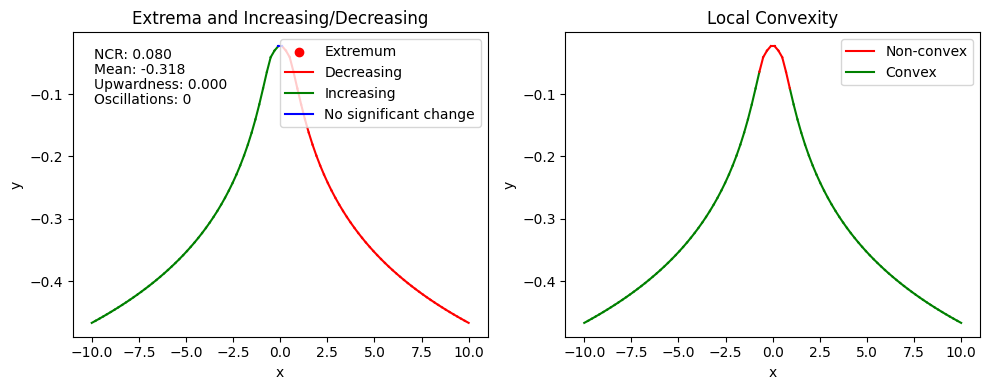

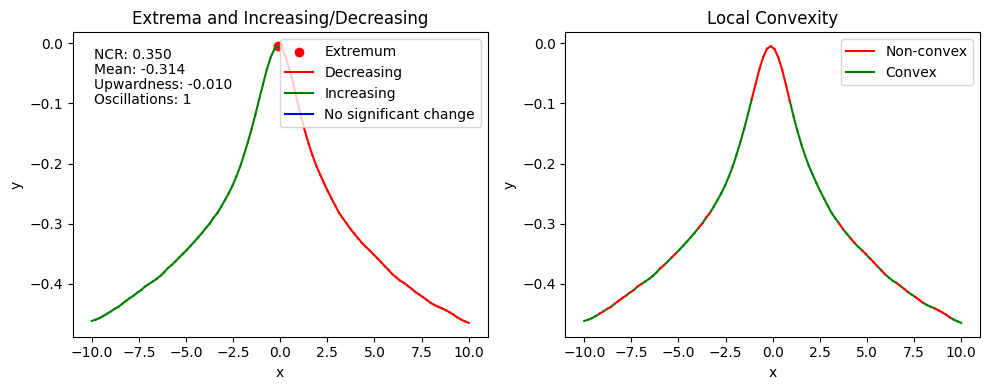

In [95]:
i = 1
y_values = data_from_loader(train_loader, 'values', idx=i)
values_pred = model.value_decoder(torch.tensor(mu_train[i]).unsqueeze(0).float())
plot_values_with_property(y_values)
plot_values_with_property(values_pred)